In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
import catboost as ctb

In [2]:
test = pd.read_csv("movies_test.csv")
train = pd.read_csv("movies_train.csv")
test.shape, train.shape

((243, 11), (600, 12))

In [3]:


def preprocess_data(data):
    data['release_year'] = data['release_time'].apply(
        lambda x: x.split('-')[0])
    data['release_month'] = data['release_time'].apply(
        lambda x: x.split('-')[1])
    data['release_day'] = data['release_time'].apply(
        lambda x: x.split('-')[2])
    temp = data.copy()
    temp['dir_prev_bfnum'] = temp["dir_prev_bfnum"].fillna(-1)
    temp['dir_prev_bfnum'] = temp["dir_prev_bfnum"].apply(str)
    groupby_director = temp.groupby('director')['dir_prev_bfnum'].apply(lambda x: '|'.join(x.replace("-1.0", ""))).reset_index()
    groupby_director["bfnum_sum"] = groupby_director["dir_prev_bfnum"].apply(lambda x: sum(list(map(float, list(filter(lambda t: t, ("0|"+x).split("|")))))))
    groupby_director["bfnum_len"] = groupby_director["dir_prev_bfnum"].apply(lambda x: len(list(map(float, list(filter(lambda t: t, ("0|"+x).split("|")))))))

    groupby_director["bfnum_avg"] = groupby_director["bfnum_sum"] / groupby_director["bfnum_len"]
    director2bfnum_avg = {i: j for i, j in zip(groupby_director["director"], groupby_director["bfnum_avg"])}

    bfnum_nan_index = data["dir_prev_bfnum"].isna()
    data.loc[bfnum_nan_index, "dir_prev_bfnum"] = data.loc[bfnum_nan_index,"director"].map(director2bfnum_avg)  
    return data


In [4]:
preprocess_data(train).isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
release_year      0
release_month     0
release_day       0
dtype: int64

In [5]:
train.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
release_year      0
release_month     0
release_day       0
dtype: int64

In [6]:
train.nunique()

title             600
distributor       169
genre              12
release_time      330
time               86
screening_rat       4
director          472
dir_prev_bfnum    266
dir_prev_num        6
num_staff         296
num_actor          17
box_off_num       586
release_year        6
release_month      12
release_day        31
dtype: int64

In [7]:
train['release_time'].apply(lambda x:len(x.split('-'))).nunique()

1

In [8]:
train['release_year'] = train['release_time'].apply(lambda x: x.split('-')[0])
train['release_month'] = train['release_time'].apply(lambda x: x.split('-')[1])
train['release_day'] = train['release_time'].apply(lambda x: x.split('-')[2])

test['release_year'] = test['release_time'].apply(lambda x: x.split('-')[0])
test['release_month'] = test['release_time'].apply(lambda x: x.split('-')[1])
test['release_day'] = test['release_time'].apply(lambda x: x.split('-')[2])

In [9]:
temp = train.copy()
temp['dir_prev_bfnum'] = temp["dir_prev_bfnum"].fillna(-1)
temp['dir_prev_bfnum'] = temp["dir_prev_bfnum"].apply(str)
groupby_director = temp.groupby('director')['dir_prev_bfnum'].apply(lambda x: '|'.join(x.replace("-1.0",""))).reset_index()

In [10]:
groupby_director["bfnum_sum"] = groupby_director["dir_prev_bfnum"].apply(lambda x: sum(list(map(float, list(filter(lambda t:t,("0|"+x).split("|")))))))

In [11]:
groupby_director["bfnum_len"] = groupby_director["dir_prev_bfnum"].apply(lambda x: len(list(map(float, list(filter(lambda t:t,("0|"+x).split("|")))))))

In [12]:
groupby_director["bfnum_avg"] = groupby_director["bfnum_sum"]/groupby_director["bfnum_len"]

In [13]:
groupby_director["director"]

0      New Pistol
1             강석필
2             강성옥
3             강우석
4             강의석
          ...    
467           황석호
468            황욱
469           황유식
470           황인호
471           황철민
Name: director, Length: 472, dtype: object

In [14]:
director2bfnum_avg = {i:j for i,j in zip(groupby_director["director"], groupby_director["bfnum_avg"])}
director2bfnum_avg

{'New Pistol': 0.0,
 '강석필': 0.0,
 '강성옥': 0.0,
 '강우석': 422410.5,
 '강의석': 0.0,
 '강형철': 5353956.833333333,
 '강효진': 18759.0,
 '강훈': 0.0,
 '경순': 5196.75,
 '계윤식': 734095.5,
 '고구마': 8807657.0,
 '고석진': 0.0,
 '공귀현': 0.0,
 '곽경택': 186431.5,
 '구모': 0.0,
 '구봉회': 0.0,
 '구수환': 0.0,
 '구자홍': 11947.0,
 '구혜선': 0.0,
 '국동석': 694996.0,
 '권오광': 0.0,
 '권우정': 0.0,
 '권중목': 0.0,
 '권칠인': 50493.333333333336,
 '권혁만': 0.0,
 '권형진': 308415.3333333333,
 '권효': 445.5,
 '기대호': 0.0,
 '김건': 0.0,
 '김경만': 0.0,
 '김경묵': 0.0,
 '김곡': 0.0,
 '김관철': 0.0,
 '김광식': 0.0,
 '김광태': 261462.5,
 '김규민': 0.0,
 '김기덕': 0.0,
 '김기영': 0.0,
 '김기훈': 0.0,
 '김달중': 0.0,
 '김대성': 0.0,
 '김대승': 673706.875,
 '김대우': 697116.7777777776,
 '김대창': 0.0,
 '김대현': 0.0,
 '김덕수': 797981.166666665,
 '김동명': 3881.5,
 '김동빈': 160.5,
 '김동원': 170.0,
 '김동주': 0.0,
 '김동후': 0.0,
 '김명균': 231220.83333333352,
 '김명서': 0.0,
 '김민석': 4400819.5,
 '김민욱': 0.0,
 '김병곤': 0.0,
 '김병준': 233848.5,
 '김봉곤': 0.0,
 '김봉은': 1767.0,
 '김봉주': 1250067.5,
 '김상만': 602600.125,
 '김상석': 404.5,
 '김상진': 2605189.6666

In [15]:
bfnum_nan_index = train["dir_prev_bfnum"].isna()
train.loc[bfnum_nan_index, "dir_prev_bfnum"] = train.loc[bfnum_nan_index, "director"].apply(lambda x: director2bfnum_avg[x])

In [16]:
train.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
release_year      0
release_month     0
release_day       0
dtype: int64

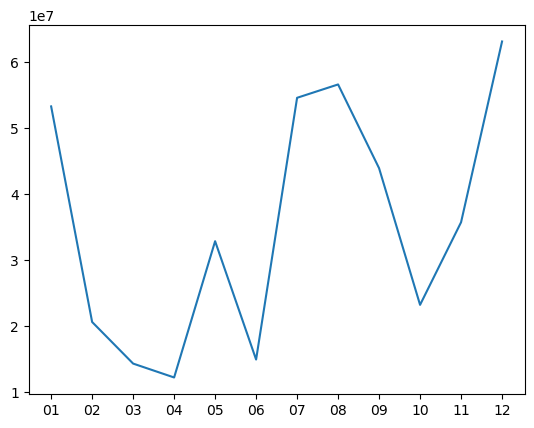

In [17]:
temp = train[["release_month", "box_off_num"]].groupby("release_month")["box_off_num"].apply(sum)
plt.plot(temp)

In [18]:
def season2item(x):
  x = int(x)
  if x in (1,7,8,9,12):
    return 1
  return 0
train["season"] = train["release_month"].apply(season2item)

In [19]:
train

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,release_year,release_month,release_day,season
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.0,0,91,2,23398,2012,11,22,0
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.5,2,387,3,7072501,2015,11,19,0
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,2013,06,05,0
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.0,2,20,6,217866,2012,07,12,1
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.0,1,251,2,483387,2010,11,04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.0,1,510,7,1475091,2014,08,13,1
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.0,1,286,6,1716438,2013,03,14,0
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,0.0,0,123,4,2475,2010,09,30,1
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,0.0,0,431,4,2192525,2015,05,14,0


In [20]:
## Label encoding
title2idx = {i:j for j, i in enumerate(train["title"].unique())}
idx2title = {i:j for j, i in title2idx.items()}
train["title"] = train["title"].map(title2idx)

distributor2idx = {i:j for j, i in enumerate(train["distributor"].unique())}
idx2distributor = {i:j for j, i in distributor2idx.items()}
train["distributor"] = train["distributor"].map(distributor2idx)

genre2idx = {i:j for j, i in enumerate(train["genre"].unique())}
idx2genre = {i:j for j, i in genre2idx.items()}
train["genre"] = train["genre"].map(genre2idx)

screening_rat2idx = {i:j for j, i in enumerate(train["screening_rat"].unique())}
idx2screening_rat = {i:j for j, i in screening_rat2idx.items()}
train["screening_rat"] = train["screening_rat"].map(screening_rat2idx)

director2idx = {i:j for j, i in enumerate(train["director"].unique())}
idx2director = {i:j for j, i in director2idx.items()}
train["director"] = train["director"].map(director2idx)


In [21]:
dataset = train.copy()
y = dataset["box_off_num"]
x = dataset

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [23]:
model_CBC = ctb.CatBoostRegressor()
model_CBC.fit(x_train, y_train)
print(model_CBC)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=3]="2011-11-03": Cannot convert 'b'2011-11-03'' to float

In [ ]:
prediction = model_CBC.predict(x_test)
((prediction-y_test)**2).mean()**0.5

82615.29198262363

In [ ]:
model_CBC.predict(test)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="용서는 없다": Cannot convert 'b'\xec\x9a\xa9\xec\x84\x9c\xeb\x8a\x94 \xec\x97\x86\xeb\x8b\xa4'' to float